# Regression Part 3: 
## Non-debut Releases

In [1]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split, KFold
from sklearn import feature_selection as f_select
from sklearn.cross_validation import cross_val_score
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from datetime import datetime as dt
#sns.set_style("darkgrid")
sns.set_style("whitegrid")
sns.set_palette("RdBu", n_colors=7)
%pylab inline

import warnings
warnings.filterwarnings('ignore')

/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Sections

### Load the pickled dataframe

In [4]:
with open("review2_2_df.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [5]:
len(df)

18218

In [ ]:
#df.head()

__Drop rows which contain debut releases__

In [6]:
df.drop(df[df.release_number == 1].index, inplace=True)

In [7]:
len(df)

9515

In [8]:
df.describe()

,score,word_count,author_review_count,total_number_releases,release_number,cum_mean_score,review_number,cum_mean_score_author,spotify_popularity
count,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9318.000000,9037.000000
mean,7.042827,694.509932,256.226064,5.986127,3.992328,7.167176,137.806306,6.956272,46.367268
std,1.261221,268.706850,222.257371,4.506928,2.957524,0.943563,152.870468,0.471103,21.595875
min,0.000000,0.000000,1.000000,2.000000,2.000000,1.000000,1.000000,3.650000,0.000000
25%,6.400000,526.000000,81.000000,3.000000,2.000000,6.750000,26.000000,6.652778,32.000000
50%,7.200000,639.000000,203.000000,5.000000,3.000000,7.310000,82.000000,7.006948,47.000000
75%,7.800000,791.000000,326.000000,7.000000,5.000000,7.766667,194.000000,7.279740,62.000000
max,10.000000,3760.000000,727.000000,34.000000,34.000000,9.750000,727.000000,9.833333,100.000000


<a id'Data Preprocessing'></a>
# Data Preprocessing

Add a column "year"

In [9]:
df["year"] = df["pub_date_x_x"].dt.year

In [10]:
df.year.describe()

count    9515.000000
mean     2010.040042
std         4.392166
min      1999.000000
25%      2006.500000
50%      2010.000000
75%      2014.000000
max      2017.000000
Name: year, dtype: float64

In [11]:
year_bins = [0, 2004, 2009, 2014, 2017]

In [12]:
year_groups = ['1999-2004', '2005-2009', '2010-2014', '2015-2017']

In [13]:
df['year_binned'] = pd.cut(df['year'], year_bins, labels=year_groups)

In [ ]:
#df.head()

### Clean some columns which are NaN

__Spotify popularity__

Change all 'NaN' to mean Spotify popularity

In [14]:
df.spotify_popularity.describe()

count    9037.000000
mean       46.367268
std        21.595875
min         0.000000
25%        32.000000
50%        47.000000
75%        62.000000
max       100.000000
Name: spotify_popularity, dtype: float64

In [15]:
len(df.loc[df.spotify_popularity.isnull()])

478

In [ ]:
#(df.loc[df.spotify_popularity.isnull()]).head()

In [16]:
df.spotify_popularity.fillna(df.spotify_popularity.mean(), inplace=True)

__Cumulative mean score (artist)__

Change all "NaN" to mean cum score

In [17]:
len(df.loc[df.cum_mean_score.isnull()])

0

In [ ]:
#df.cum_mean_score.fillna(df.cum_mean_score.mean(), inplace=True)

In [ ]:
#df.loc[df['total_number_releases'] == 1].head()

__Cumulative mean score (author)__

Change all "NaN" to mean cum score

In [18]:
len(df.loc[df.cum_mean_score_author.isnull()])

197

In [19]:
df.cum_mean_score_author.fillna(df.cum_mean_score_author.mean(), inplace=True)

In [ ]:
#df.loc[df['author_review_count'] == 1].head()


__Double check that we haven't missed any "NaN" values:__

In [20]:
df.isnull().values.any()

False

### Start exploring the data

In [21]:
len(df)

9515

In [22]:
df.describe()

,score,word_count,year,author_review_count,total_number_releases,release_number,cum_mean_score,review_number,cum_mean_score_author,spotify_popularity
count,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000,9515.000000
mean,7.042827,694.509932,2010.040042,256.226064,5.986127,3.992328,7.167176,137.806306,6.956272,46.367268
std,1.261221,268.706850,4.392166,222.257371,4.506928,2.957524,0.943563,152.870468,0.466200,21.046377
min,0.000000,0.000000,1999.000000,1.000000,2.000000,2.000000,1.000000,1.000000,3.650000,0.000000
25%,6.400000,526.000000,2006.500000,81.000000,3.000000,2.000000,6.750000,26.000000,6.666667,33.000000
50%,7.200000,639.000000,2010.000000,203.000000,5.000000,3.000000,7.310000,82.000000,7.000000,46.367268
75%,7.800000,791.000000,2014.000000,326.000000,7.000000,5.000000,7.766667,194.000000,7.275000,62.000000
max,10.000000,3760.000000,2017.000000,727.000000,34.000000,34.000000,9.750000,727.000000,9.833333,100.000000


### Look at some histograms:

__Score__

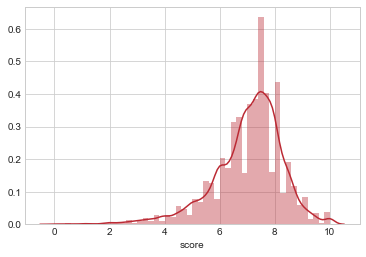

In [23]:
sns.distplot(df.score);

__Spotify popularity__

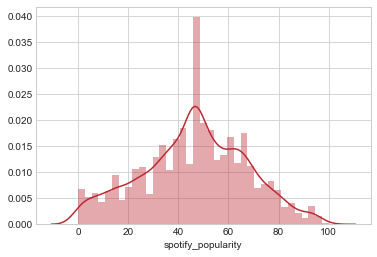

In [24]:
sns.distplot(df.spotify_popularity);

__Word count__

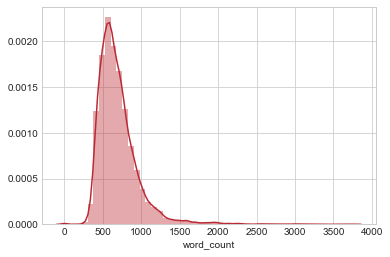

In [25]:
sns.distplot(df.word_count);

__Year__

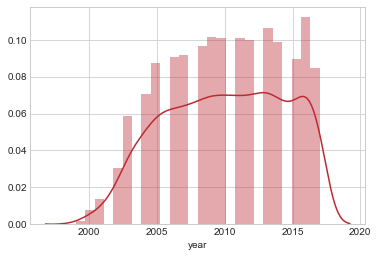

In [26]:
sns.distplot(df.year);

### Initial look at correlation between features

In [27]:
df.corr()

,score,word_count,year,author_review_count,total_number_releases,release_number,cum_mean_score,review_number,cum_mean_score_author,spotify_popularity
score,1.000000,0.277826,0.062480,-0.015530,0.103637,0.061630,0.710390,0.038382,0.352373,0.009693
word_count,0.277826,1.000000,0.176460,0.029195,0.192502,0.202555,0.161836,0.091193,0.096988,0.343621
year,0.062480,0.176460,1.000000,-0.109038,-0.082730,0.266882,0.033909,0.180440,0.067286,0.176551
author_review_count,-0.015530,0.029195,-0.109038,1.000000,-0.003956,0.001146,0.006245,0.780575,-0.127372,-0.041004
total_number_releases,0.103637,0.192502,-0.082730,-0.003956,1.000000,0.761264,0.107770,0.004719,0.051971,0.341407
release_number,0.061630,0.202555,0.266882,0.001146,0.761264,1.000000,0.058047,0.098294,0.052464,0.259837
cum_mean_score,0.710390,0.161836,0.033909,0.006245,0.107770,0.058047,1.000000,0.059070,0.290049,-0.037067
review_number,0.038382,0.091193,0.180440,0.780575,0.004719,0.098294,0.059070,1.000000,-0.019206,0.004681
cum_mean_score_author,0.352373,0.096988,0.067286,-0.127372,0.051971,0.052464,0.290049,-0.019206,1.000000,-0.061334
spotify_popularity,0.009693,0.343621,0.176551,-0.041004,0.341407,0.259837,-0.037067,0.004681,-0.061334,1.000000


In [28]:
df.corr().score.sort_values(ascending=False)

score                    1.000000
cum_mean_score           0.710390
cum_mean_score_author    0.352373
word_count               0.277826
total_number_releases    0.103637
year                     0.062480
release_number           0.061630
review_number            0.038382
spotify_popularity       0.009693
author_review_count     -0.015530
Name: score, dtype: float64

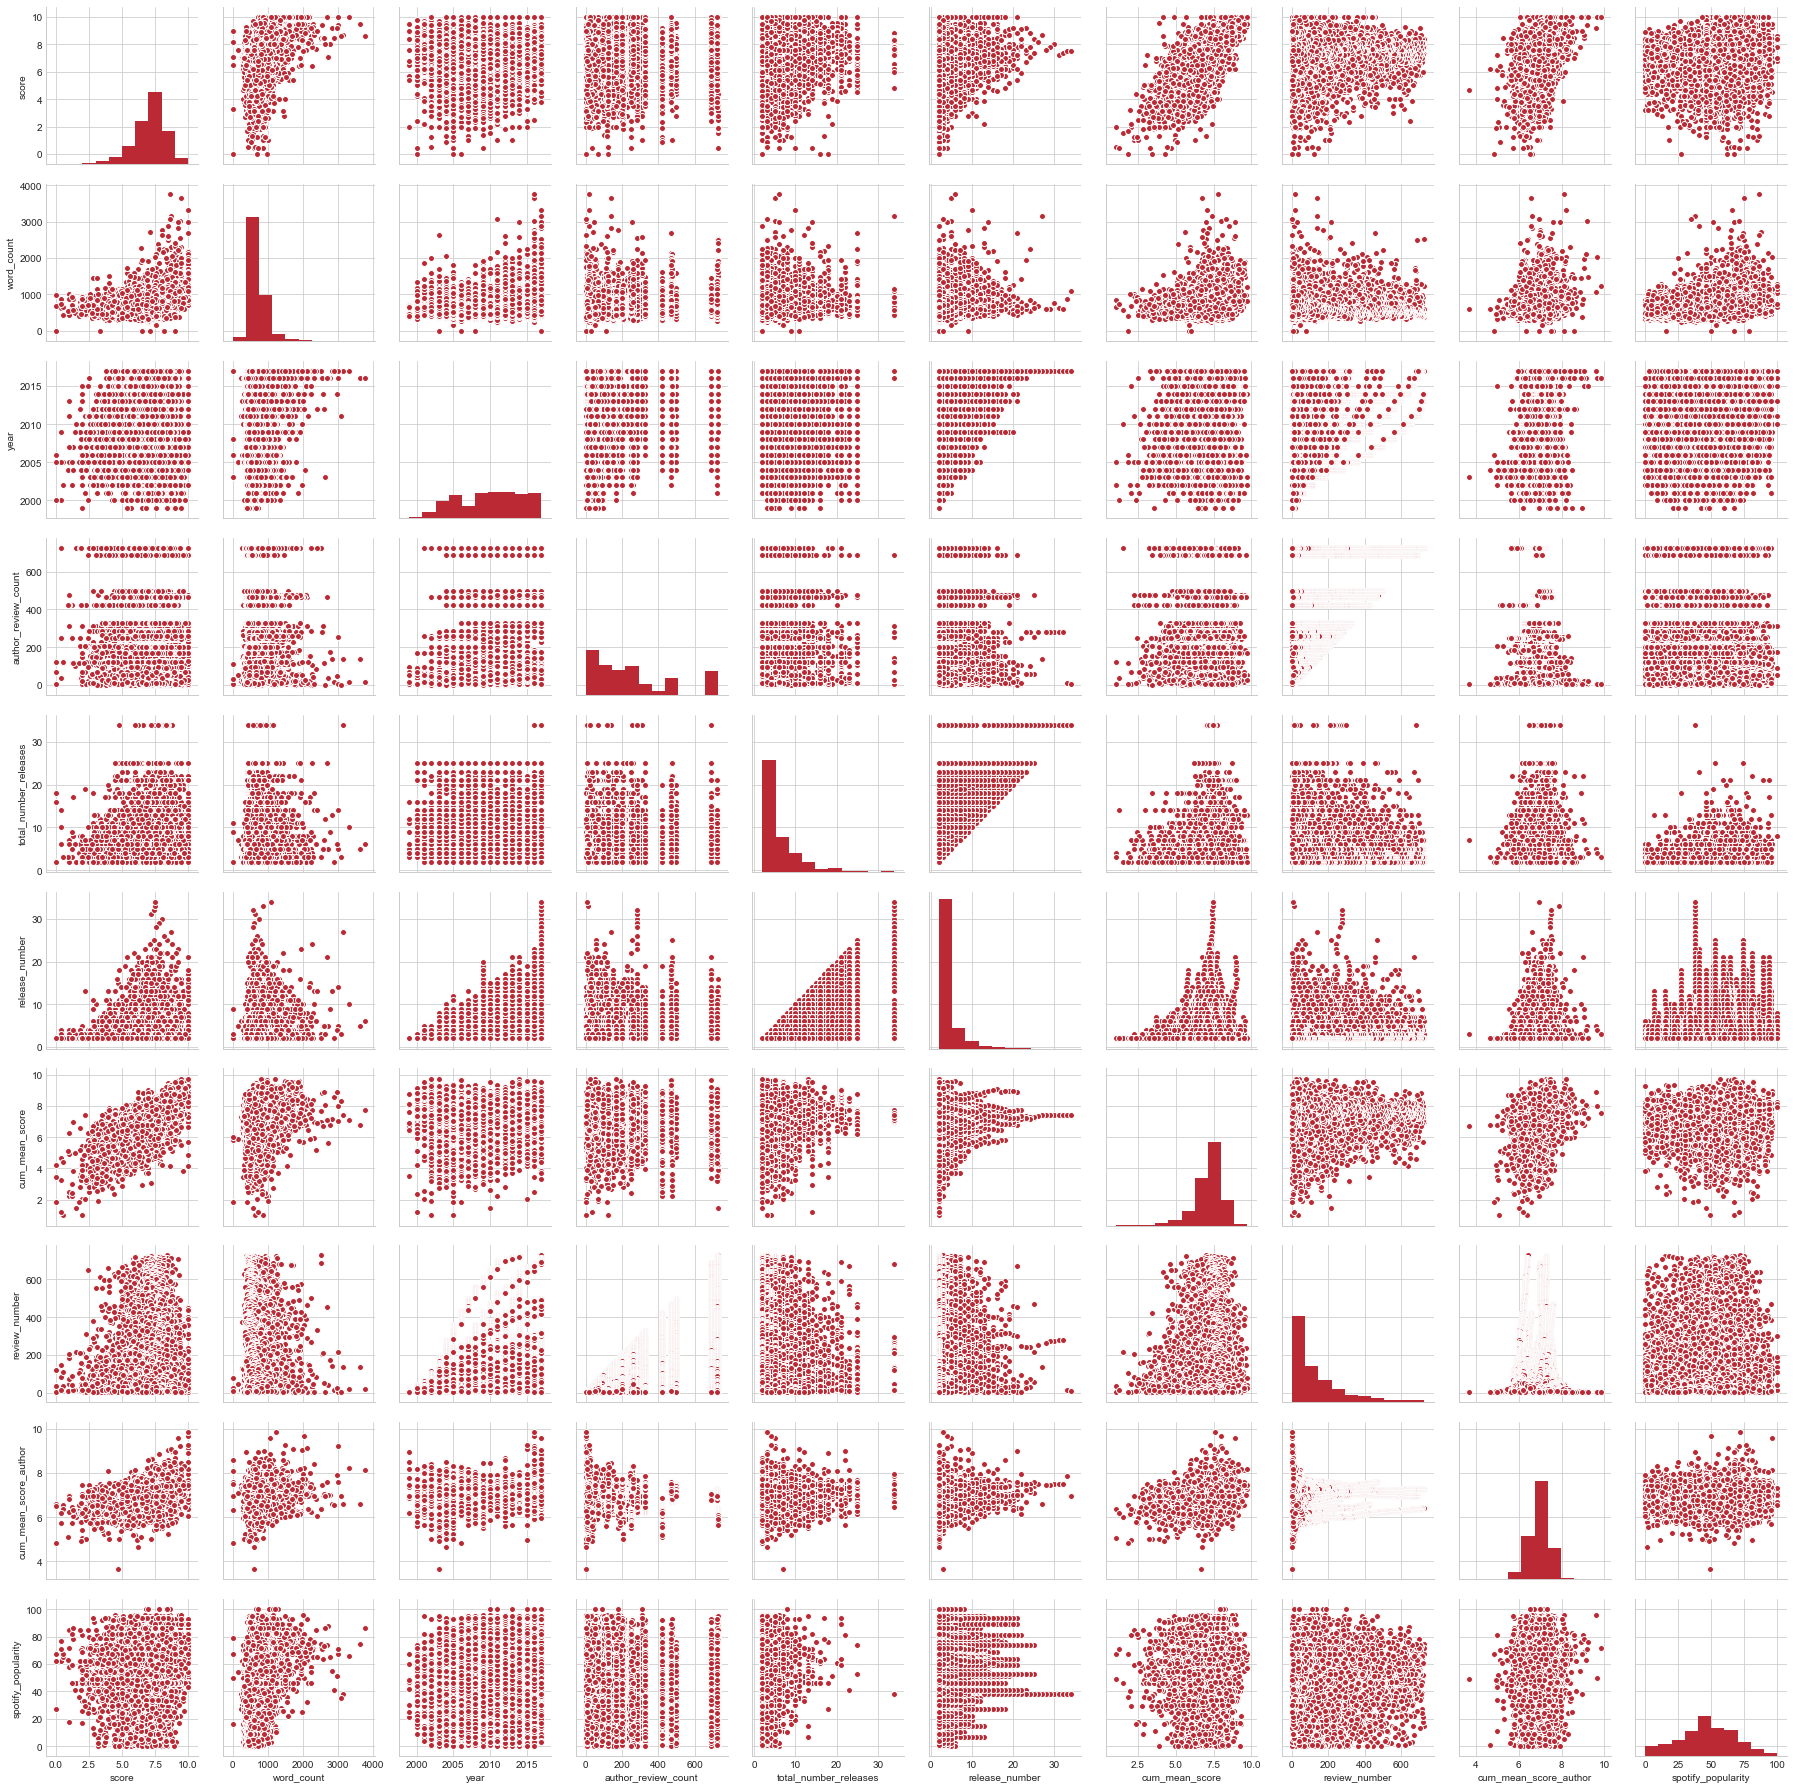

In [29]:
sns.pairplot(df);

### Look at correlations individually

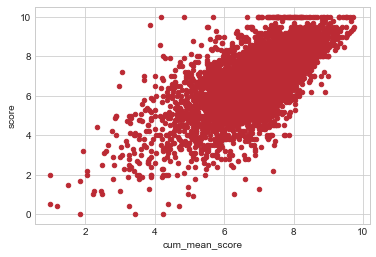

In [30]:
df.plot(kind='scatter', x='cum_mean_score', y='score');

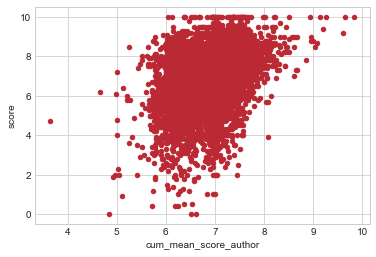

In [31]:
df.plot(kind='scatter', x='cum_mean_score_author', y='score');

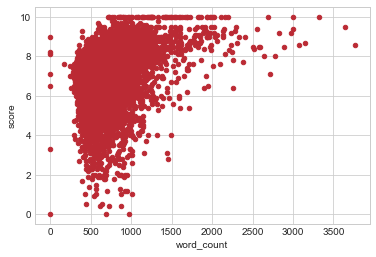

In [32]:
df.plot(kind='scatter', x='word_count', y='score');

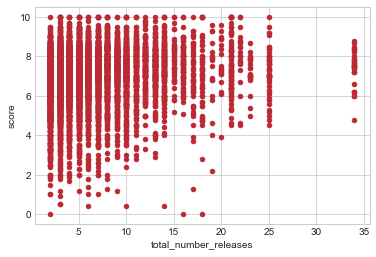

In [33]:
df.plot(kind='scatter', x='total_number_releases', y='score');

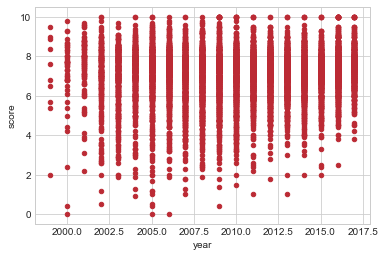

In [34]:
df.plot(kind='scatter', x='year', y='score');

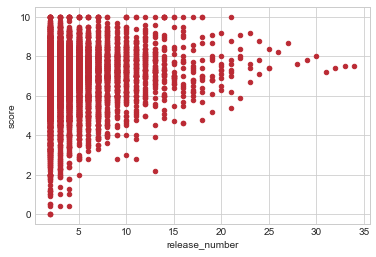

In [35]:
df.plot(kind='scatter', x='release_number', y='score');

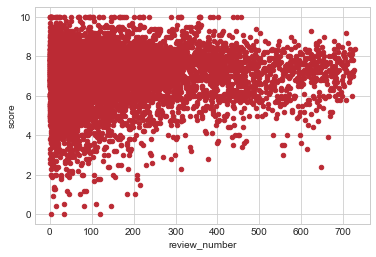

In [36]:
df.plot(kind='scatter', x='review_number', y='score');

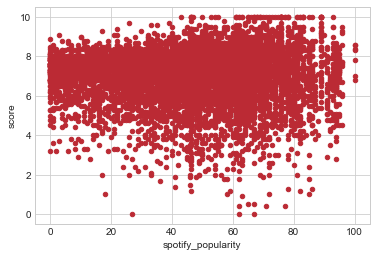

In [37]:
df.plot(kind='scatter', x='spotify_popularity', y='score');

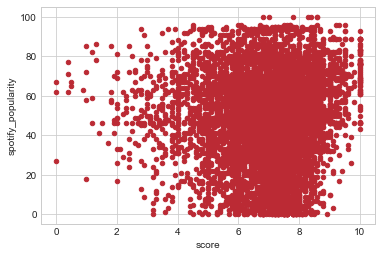

In [38]:
df.plot(kind='scatter', x='score', y='spotify_popularity');

__Look closely just at the highest rated Pitchfork albums.__

__... does that score carry over to Spotify popularity?__

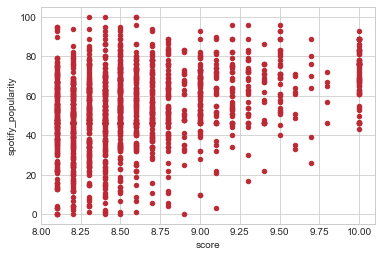

In [39]:
df[df.score > 8].plot(kind='scatter', x='score', y='spotify_popularity');

### Create dummy variables from categorical variables

__[SKIP] Best New Music / Best New Reissue__

Note: I later decided NOT to include this feature since "best new music" is likely to be assigned AFTER a score is given.

In [ ]:
#df['best'] = np.where(df['bnm'] != 'None', 1.0, 0.0)

In [ ]:
#df.loc[df['bnm'] == "None"]

In [ ]:
#df = df.drop('best', axis=1)

__Record labels__

Sub Pop is the label with the most number of releases that have been reviewed by Pitchfork.  It is also claimed that Pitchfork favours this label over others.

In [40]:
df.label.value_counts(ascending=False).head()

Self-released    224
Drag City        176
Sub Pop          172
Merge            171
Warp             163
Name: label, dtype: int64

In [41]:
df['subpop'] = np.where(df['label'] == 'Sub Pop', 1.0, 0.0)

Pitchfork is big on independent music

In [42]:
df['self_released'] = np.where(df['label'] == 'Self-released', 1.0, 0.0)

In [ ]:
#df.loc[df['label'] == "Sub Pop"]

__Genre__

In [43]:
df.genre.value_counts(ascending=False)

Rock            3955
Electronic      2057
Experimental     983
Rap              849
Pop/R&B          487
Metal            374
Folk/Country     354
None             287
Jazz              90
Global            79
Name: genre, dtype: int64

In [44]:
X_genre = patsy.dmatrix('genre', data=df, return_type='dataframe')

In [45]:
X_genre.head()

,Intercept,genre[T.Experimental],genre[T.Folk/Country],genre[T.Global],genre[T.Jazz],genre[T.Metal],genre[T.None],genre[T.Pop/R&B],genre[T.Rap],genre[T.Rock]
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [46]:
df = df.join(X_genre)

In [47]:
df['genre[T.Electronic]'] = np.where(df['genre'] == 'Electronic', 1.0, 0.0)

In [ ]:
#df.head()

__Author title__

In [48]:
df.author_title.value_counts(ascending=False)

Contributor                  6986
None                         1230
Contributing Editor           306
Executive Editor              299
Senior Staff Writer           221
Senior Editor                 179
Contributing Writer            61
Deputy News Editor             58
Associate Staff Writer         53
Tracks Coordinator             33
Associate Reviews Editor       21
Editor-in-Chief                19
Associate Features Editor      15
Assistant Editor               15
Associate Editor               13
News Director                   4
Managing Editor                 1
Contributor                     1
Name: author_title, dtype: int64

In [49]:
df['title[T.Contributor]'] = np.where(df['author_title'] == 'Contributor', 1.0, 0.0)

In [50]:
df['title[T.Contributing_Editor]'] = np.where(df['author_title'] == 'Contributing Editor', 1.0, 0.0)

In [51]:
df['title[T.Executive_Editor]'] = np.where(df['author_title'] == 'Executive Editor', 1.0, 0.0)

In [52]:
df['title[T.Senior_Staff_Writer]'] = np.where(df['author_title'] == 'Senior Staff Writer', 1.0, 0.0)

In [ ]:
#df['title[T.Senior_Editor]'] = np.where(df['author_title'] == 'Senior Editor', 1.0, 0.0)

__Year_binned__

In [53]:
df.year_binned.value_counts(ascending=False)

2010-2014    3340
2005-2009    3083
2015-2017    1886
1999-2004    1206
Name: year_binned, dtype: int64

In [54]:
df['1999-2004'] = np.where(df['year_binned'] == '1999-2004', 1.0, 0.0)

In [55]:
df['2005-2009'] = np.where(df['year_binned'] == '2005-2009', 1.0, 0.0)

In [56]:
df['2010-2014'] = np.where(df['year_binned'] == '2010-2014', 1.0, 0.0)

In [57]:
df['2015-2017'] = np.where(df['year_binned'] == '2015-2017', 1.0, 0.0)

### Have another look at correlations

In [ ]:
#df.corr()

In [58]:
df.corr().score.sort_values(ascending=False)

score                           1.000000
cum_mean_score                  0.710390
cum_mean_score_author           0.352373
word_count                      0.277826
total_number_releases           0.103637
title[T.Executive_Editor]       0.100212
2015-2017                       0.092443
genre[T.Experimental]           0.086657
year                            0.062480
release_number                  0.061630
genre[T.Jazz]                   0.049801
review_number                   0.038382
genre[T.Folk/Country]           0.033261
title[T.Contributing_Editor]    0.032070
subpop                          0.026354
genre[T.Global]                 0.024444
spotify_popularity              0.009693
genre[T.Pop/R&B]                0.007050
1999-2004                       0.005974
title[T.Contributor]           -0.001526
genre[T.None]                  -0.004089
genre[T.Rock]                  -0.008959
genre[T.Metal]                 -0.012101
author_review_count            -0.015530
self_released   

In [59]:
df.columns

Index(['album', 'artist', 'author', 'author_title', 'bnm', 'genre', 'label',
       'score', 'word_count', 'year', 'pub_date_x_x', 'author_review_count',
       'total_number_releases', 'release_number', 'cum_mean_score',
       'review_number', 'cum_mean_score_author', 'spotify_popularity',
       'year_binned', 'subpop', 'self_released', 'Intercept',
       'genre[T.Experimental]', 'genre[T.Folk/Country]', 'genre[T.Global]',
       'genre[T.Jazz]', 'genre[T.Metal]', 'genre[T.None]', 'genre[T.Pop/R&B]',
       'genre[T.Rap]', 'genre[T.Rock]', 'genre[T.Electronic]',
       'title[T.Contributor]', 'title[T.Contributing_Editor]',
       'title[T.Executive_Editor]', 'title[T.Senior_Staff_Writer]',
       '1999-2004', '2005-2009', '2010-2014', '2015-2017'],
      dtype='object')

## Begin modeling...
### First, define y and X

__Keep: word count, binned year, cum mean score author, subpop, genres, author title....__

In [60]:
y = df.score
x = df.drop(['album', 'artist', 'author', 'author_title', 'bnm', 'genre', 'label',
       'score', 'year', 'pub_date_x_x', 'author_review_count',
       'total_number_releases', 'release_number', 'year_binned', 
       'Intercept', 'genre[T.None]'],1)

In [61]:
x.columns

Index(['word_count', 'cum_mean_score', 'review_number',
       'cum_mean_score_author', 'spotify_popularity', 'subpop',
       'self_released', 'genre[T.Experimental]', 'genre[T.Folk/Country]',
       'genre[T.Global]', 'genre[T.Jazz]', 'genre[T.Metal]',
       'genre[T.Pop/R&B]', 'genre[T.Rap]', 'genre[T.Rock]',
       'genre[T.Electronic]', 'title[T.Contributor]',
       'title[T.Contributing_Editor]', 'title[T.Executive_Editor]',
       'title[T.Senior_Staff_Writer]', '1999-2004', '2005-2009', '2010-2014',
       '2015-2017'],
      dtype='object')

In [62]:
x.head()

,word_count,cum_mean_score,review_number,cum_mean_score_author,spotify_popularity,subpop,self_released,genre[T.Experimental],genre[T.Folk/Country],genre[T.Global],...,genre[T.Rock],genre[T.Electronic],title[T.Contributor],title[T.Contributing_Editor],title[T.Executive_Editor],title[T.Senior_Staff_Writer],1999-2004,2005-2009,2010-2014,2015-2017
0,1409,8.020000,18,8.072222,46.367268,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,842,8.000000,1,6.956272,64.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,794,6.883333,497,7.059155,45.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,825,7.842857,687,6.973071,58.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,840,7.760000,8,7.512500,54.000000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [63]:
X = preprocessing.normalize(x, axis=0, norm='max')
X = pd.DataFrame(X)
X.columns = x.columns

Do not need to normalize y since it is normally distributed.

In [64]:
X.columns

Index(['word_count', 'cum_mean_score', 'review_number',
       'cum_mean_score_author', 'spotify_popularity', 'subpop',
       'self_released', 'genre[T.Experimental]', 'genre[T.Folk/Country]',
       'genre[T.Global]', 'genre[T.Jazz]', 'genre[T.Metal]',
       'genre[T.Pop/R&B]', 'genre[T.Rap]', 'genre[T.Rock]',
       'genre[T.Electronic]', 'title[T.Contributor]',
       'title[T.Contributing_Editor]', 'title[T.Executive_Editor]',
       'title[T.Senior_Staff_Writer]', '1999-2004', '2005-2009', '2010-2014',
       '2015-2017'],
      dtype='object')

In [65]:
X.head()

,word_count,cum_mean_score,review_number,cum_mean_score_author,spotify_popularity,subpop,self_released,genre[T.Experimental],genre[T.Folk/Country],genre[T.Global],...,genre[T.Rock],genre[T.Electronic],title[T.Contributor],title[T.Contributing_Editor],title[T.Executive_Editor],title[T.Senior_Staff_Writer],1999-2004,2005-2009,2010-2014,2015-2017
0,0.374734,0.822564,0.024759,0.820904,0.463673,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.223936,0.820513,0.001376,0.707417,0.640000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.211170,0.705983,0.683631,0.717880,0.450000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.219415,0.804396,0.944979,0.709126,0.580000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.223404,0.795897,0.011004,0.763983,0.540000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Baseline R2

In [66]:
baseline = LinearRegression()
baseline.fit(X,y)
baseline.score(X,y)

0.55544484474981104

__Try dropping a few features that were negatively correlated__

In [67]:
X.columns

Index(['word_count', 'cum_mean_score', 'review_number',
       'cum_mean_score_author', 'spotify_popularity', 'subpop',
       'self_released', 'genre[T.Experimental]', 'genre[T.Folk/Country]',
       'genre[T.Global]', 'genre[T.Jazz]', 'genre[T.Metal]',
       'genre[T.Pop/R&B]', 'genre[T.Rap]', 'genre[T.Rock]',
       'genre[T.Electronic]', 'title[T.Contributor]',
       'title[T.Contributing_Editor]', 'title[T.Executive_Editor]',
       'title[T.Senior_Staff_Writer]', '1999-2004', '2005-2009', '2010-2014',
       '2015-2017'],
      dtype='object')

In [68]:
X2 = X.drop(['subpop', 'self_released', 'genre[T.Metal]',
       'genre[T.Pop/R&B]', 'genre[T.Rap]', 'genre[T.Rock]',
       'title[T.Senior_Staff_Writer]', '1999-2004',
       '2005-2009'],1)

In [69]:
X2.columns

Index(['word_count', 'cum_mean_score', 'review_number',
       'cum_mean_score_author', 'spotify_popularity', 'genre[T.Experimental]',
       'genre[T.Folk/Country]', 'genre[T.Global]', 'genre[T.Jazz]',
       'genre[T.Electronic]', 'title[T.Contributor]',
       'title[T.Contributing_Editor]', 'title[T.Executive_Editor]',
       '2010-2014', '2015-2017'],
      dtype='object')

In [70]:
baseline2 = LinearRegression()
baseline2.fit(X2,y)
baseline2.score(X2,y)

0.55468205601549436

## Test-train split

In [75]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

model_tt= LinearRegression()
model_tt.fit(X_train,y_train)

print(f"train R2: {model_tt.score(X_train,y_train)}, "
      f"test R2: {model_tt.score(X_test,y_test)}")

train R2: 0.5479485929376449, test R2: 0.5711696049695779


## Cross validation

In [ ]:
alpha = 0.05

sig_cols = [
    c for c in X.columns
    if f_select.f_regression(X[[c]], y)[1][0] < alpha
]

X_sig = X[sig_cols]

In [ ]:
sig_cols

In [ ]:
est_cv = LinearRegression()
cross_val_score(est_cv, X_sig, y, cv=5, scoring="r2").mean()

__Features selection function:__

In [72]:
def find_sig_cols(X, y, alpha=0.05):
    sig_cols = []
    for c in X.columns:
        pvalue = f_select.f_regression(X[[c]], y)[1][0]
        if pvalue <= alpha:
            sig_cols.append(c)

    return sig_cols

In [74]:
kf = KFold(n=len(X), n_folds=5, shuffle=True)
est_cv2 = LinearRegression()

all_scores = []

for train_i, test_i in kf:
    x_train = X.iloc[train_i]
    y_train = y.iloc[train_i].reshape(-1, 1)
    x_test = X.iloc[test_i]
    y_test = y.iloc[test_i].reshape(-1, 1)

    sig_cols = find_sig_cols(x_train, y_train)
    est_cv2.fit(x_train[sig_cols], y_train)
    r2 = est_cv2.score(x_test[sig_cols], y_test)
    all_scores.append(r2)

np.mean(all_scores)

0.55246403918094877

## Regularization

### Ridge regression

In [76]:
est_r1 = Ridge()
est_r1.fit(X_train, y_train)
est_r1.score(X_test, y_test)

0.57117283540042296

In [77]:
est_r1.coef_

array([  7.54015546e-04,   8.49201747e-01,  -1.83169143e-04,
         4.27050802e-01,  -5.29062599e-04,   4.64692854e-02,
        -5.89751715e-02,   2.30948298e-02,   3.89992115e-02,
        -6.30774354e-02,  -5.66596716e-02,  -3.94987194e-02,
         1.12384545e-01,  -3.21910155e-02,   1.99039625e-02,
        -7.76157250e-02,  -4.49868783e-02,  -1.13758784e-01,
        -3.90829272e-02,   1.32500856e-01,  -5.61109967e-02,
        -1.22697895e-02,   1.82761259e-02,   5.01046604e-02])

In [78]:
zipped = list(zip(list(X_train.columns), est_r1.coef_))
features = sorted(zipped, key=lambda t: t[1], reverse=True)
features

[('cum_mean_score', 0.8492017468626194),
 ('cum_mean_score_author', 0.4270508016065438),
 ('title[T.Senior_Staff_Writer]', 0.13250085649044877),
 ('genre[T.Pop/R&B]', 0.11238454499248518),
 ('2015-2017', 0.050104660395596509),
 ('subpop', 0.046469285354447859),
 ('genre[T.Folk/Country]', 0.038999211530930583),
 ('genre[T.Experimental]', 0.023094829817148541),
 ('genre[T.Rock]', 0.019903962490002744),
 ('2010-2014', 0.018276125877070157),
 ('word_count', 0.00075401554606057634),
 ('review_number', -0.00018316914318106684),
 ('spotify_popularity', -0.00052906259880201238),
 ('2005-2009', -0.012269789535418211),
 ('genre[T.Rap]', -0.032191015480105618),
 ('title[T.Executive_Editor]', -0.039082927236942872),
 ('genre[T.Metal]', -0.039498719393902662),
 ('title[T.Contributor]', -0.044986878325492231),
 ('1999-2004', -0.056110996737937846),
 ('genre[T.Jazz]', -0.056659671591814287),
 ('self_released', -0.058975171533250194),
 ('genre[T.Global]', -0.063077435358642533),
 ('genre[T.Electronic]

In [79]:
rcv = RidgeCV(alphas=(0.1, 1.0, 10.0, 0.0, 1e-8, 1e-5, 1e-1),cv=10)
r = rcv.fit(X_train, y_train)
rcv.score(X_test, y_test)

0.5712001734578267

In [80]:
rcv.alpha_

10.0

## Lasso regression

In [81]:
est_l1 = Lasso()
est_l1.fit(X_train, y_train)
est_l1.score(X_test, y_test)

0.087528354580143297

In [82]:
lcv = LassoCV(alphas=(0.1, 1.0, 10.0, 0.0, 1e-8, 1e-5, 1e-1),cv=10)
lcv.fit(X_train, y_train)
lcv.score(X_test, y_test)

0.57116895921809097

In [83]:
lcv.alpha_

1.0000000000000001e-05

## Polynomial features

__Degree: 2__

In [84]:
est_p2 = make_pipeline(PolynomialFeatures(2), LinearRegression())
est_p2.fit(X_train, y_train)
est_p2.score(X_test, y_test)

0.57413420878165045

__Degree: 3__

In [86]:
# est_p3 = make_pipeline(PolynomialFeatures(3), LinearRegression())
# est_p3.fit(X_train, y_train)
# est_p3.score(X_test, y_test)

## Create dataframe columns for 'predicted score' and 'residual'

In [87]:
df['predicted_score'] = model_tt.predict(x)

In [88]:
df['residual'] = df['predicted_score'] - df['score']

In [92]:
#df.sort_values('residual', ascending=False)[['artist', 'album', 'release_number', 'cum_mean_score', 'cum_mean_score_author', 'score', 'predicted_score', 'residual']]


(0, 10)

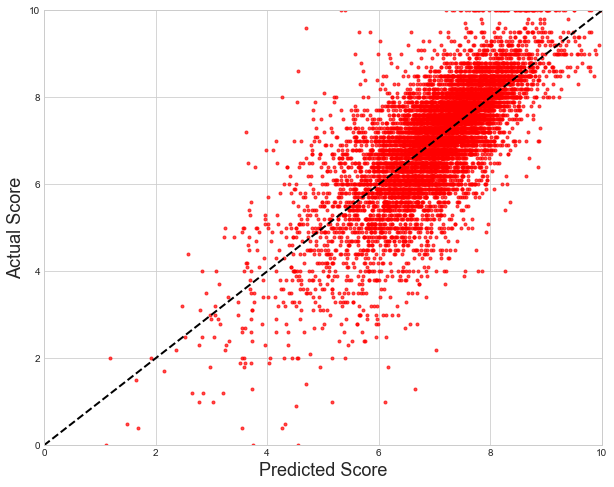

In [91]:
a = range(11)
b = range(11)

plt.figure(figsize=(10,8))
plt.scatter(df['predicted_score'], df['score'], marker='.', alpha=0.7, color='red')
plt.plot(a, b, 'r--', linewidth=2, color='black')
#plt.title('Model Performance', fontsize=18)
plt.ylabel('Actual Score', fontsize=18)
plt.xlabel('Predicted Score', fontsize=18)
plt.xlim(0, 10)
plt.ylim(0, 10)

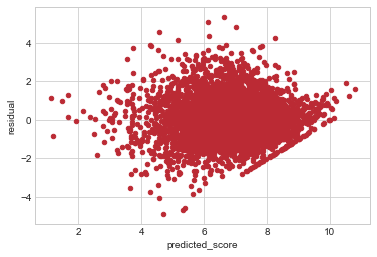

In [93]:
df.plot(kind='scatter', x='predicted_score', y='residual');

In [102]:
mask_r = (df['residual'] <= -4.5) | (df['residual'] >= 5) & (df['genre'] != "None")

In [103]:
df[mask_r][['artist', 'album', 'genre', 'release_number', 'cum_mean_score', 'cum_mean_score_author', 'score', 'predicted_score', 'residual']].sort_values('residual', ascending=False)


,artist,album,genre,release_number,cum_mean_score,cum_mean_score_author,score,predicted_score,residual
11792,Bob Dylan,DYLAN,Rock,4,7.000000,6.050000,1.3,6.645258,5.345258
4808,Pixies,EP-1,Rock,4,6.300000,7.005978,1.0,6.107101,5.107101
8151,Weezer,Pinkerton [Deluxe Edition],Rock,7,4.857143,6.045581,10.0,5.391480,-4.608520
1860,Metallica,Ride the Lightning,Metal,4,4.175000,7.506250,10.0,5.315972,-4.684028
10925,Liz Phair,Exile in Guyville [15th Anniversary Edition],Rock,3,3.866667,7.358421,9.6,4.691524,-4.908476


In [104]:
mask_good = (df['residual'] >= -0.5) & (df['residual'] <= 0.5) & (df['genre'] != "None")

In [105]:
df[mask_good][['artist', 'album', 'genre', 'release_number', 'cum_mean_score', 'cum_mean_score_author', 'score', 'predicted_score', 'residual']].sort_values('residual', ascending=False)


,artist,album,genre,release_number,cum_mean_score,cum_mean_score_author,score,predicted_score,residual
282,Baio,Man of the World,Electronic,2,6.400000,6.420000,5.6,6.099983,0.499983
14007,The Darkness,One Way Ticket to Hell...and Back,Metal,2,7.450000,6.348734,6.5,6.999788,0.499788
6955,Future of the Left,Polymers Are Forever EP,Rock,3,7.433333,6.022297,6.3,6.799611,0.499611
5471,Parenthetical Girls,Privilege,Rock,3,7.233333,7.019608,6.5,6.999555,0.499555
16796,Sigur Rós,Sigur 1/Sigur 9 EP,Rock,4,7.650000,7.156522,7.1,7.599535,0.499535
1584,Deerhoof,The Magic,Experimental,15,7.433333,7.080000,6.9,7.399015,0.499015
14639,Quasimoto,The Further Adventures of Lord Quas,Rap,2,7.850000,7.221739,7.0,7.498591,0.498591
17231,The Sea and Cake,One Bedroom,Experimental,2,8.000000,6.158228,7.0,7.498097,0.498097
3651,Earth,Primitive and Deadly,Metal,8,7.375000,7.287719,7.0,7.498048,0.498048
5094,Surfer Blood,Pythons,Rock,3,7.366667,6.700000,6.7,7.197614,0.497614


In [ ]:
zipped = list(zip(list(x.columns), model_tt.coef_))
features = sorted(zipped, key=lambda t: t[1], reverse=True)
features